In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import torch
from dataset_utils.woodscape import WoodScapeDataModule
from dataset_utils import WoodScapeSoilingDataModule
from deeplab_v3p import DeepLabV3PlusModule

In [2]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import get_latent_representation_mcd_samples, apply_dropout
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z

Global steps for using the package:

* **To make an evaluation** of how the component performs at classifying one or several Out-of-Distribution (OoD) test datasets with respect to an In-Distribution (InD) test dataset:

    1. Load your Dataloader Modules for InD and OoD datasets. For the InD it is necessary to use the train and a test set; for the OoD only the test set is needed.
    2. Load your DNN Module trained on the InD dataset.
    3. Add Hook to the target layer of the DNN Module for MC samples extraction, making sure dropout or dropblock is activated.
    4. Get Monte-Carlo (MC) samples for InD samples dataloader, and OoD samples dataloader.
        * Note: make sure the dataloader is compatible with any of the functions for samples extraction: Look at the README.
    5. Get Entropy from InD and OoD MC samples
    6. Instantiate density estimator (KDE for LaRED, or Mahalanobis for LaREM)
    7. Evaluate OoD performance results to obtain good configuration parameters: Whether laRED or laREM perform better and how many PCA components to use (if better than not using PCA)

* **To perform inference** using the component, that is: make predictions using the model, obtain the confidence score and classify images as InD or OoD:        
    1. Load your trained DNN Module
    2. Add Hook to the target layer of the DNN Module for MC samples extraction.
    3. Load previously calculated InD entropies from evaluation step, from the train and a test set.
    4. Optionally train a PCA module on the InD train entropies with an appropriate number of components, according to evaluation results.
    5. Instantiate one density estimator (either KDE for LaRED, or Mahalanobis for LaREM). Stability tests favor LaREM so we recommend it as the default option.
    6. Calculate a threshold for classification using the InD test set
    7. Perform inference on new images: get predictions and confidence scores
    8. Visualize predictions and classify new images as InD or OoD according to the score and the threshold

Note that in any case the entropies from the InD train and test set are necessary to be able to perform inference, because the components modules (PCA module and postprocessor module) need to be trained before proceeding to inference, and a threshold needs to be calculated.

Also, stability tests favor LaREM, which tends to work well with about 256 components across different benchmarks. So in case of doubt we recommend testing this configuration.        

In this notebook we will cover steps 1 to 5 of the evaluation step. Remember that training a model on the InD data is a previous requirement, so you should already have a checkpoint of the model. 
In [Notebook 2: Evaluate LaREx](https://git.irt-systemx.fr/confianceai/ec_3/n6_monitoring/component-latent-space/ood-latent-space/-/blob/4-finish-library/examples/2_example_deeplab_segmentation_analysis.ipynb?ref_type=heads) steps 6 and 7 of the evaluation mode are demonstrated.
Finally in [Notebook 3: Inference with LaREx](https://git.irt-systemx.fr/confianceai/ec_3/n6_monitoring/component-latent-space/ood-latent-space/-/blob/4-finish-library/examples/3_performing_inference.ipynb?ref_type=heads) all inference steps are illustrated.

# Load datasets

## Load Datamodules

The data should already be downloaded on the system.

In [3]:
ws_dataset_path = './Woodscapes_dataset/'
batch_size = 1
layer_type = "Conv"

cmap = {0: [0, 0, 0],  # "void"
        1: [128, 64, 128],  # "road",
        2: [69, 76, 11],  # "lanemarks",
        3: [0, 255, 0],  # "curb",
        4: [220, 20, 60],  # "person",
        5: [255, 0, 0],  # "rider",
        6: [0, 0, 142],  # "vehicles",
        7: [119, 11, 32],  # "bicycle",
        8: [0, 0, 230],  # "motorcycle",
        9: [220, 220, 0]  # "traffic_sign",
        }

# same values as in VainF Repository! - Probably not the best Values for Woodscapes!
ws_dlv3p_norm_mean = [0.485, 0.456, 0.406]
ws_dlv3p_norm_std = [0.229, 0.224, 0.225]

In [4]:
# InD high resolution
ws_dm_normal_dlv3p = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


In [5]:
# InD lower resolution
ws_dm_normal_dlv3p_256_512 = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(256, 512),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p_256_512.setup()

DATASET Shuffle Random SEED:  9290


In [6]:
# OoD Anomalies high resolution
ws_dm_anomal_dlv3p = WoodScapeDataModule(dataset_dir=ws_dataset_path,
                                         img_size=(483, 640),
                                         batch_size=batch_size,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_anomal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


## Instantiate dataloaders

In [7]:
# InD High res
ws_dlv3p_train_loader = ws_dm_normal_dlv3p.train_dataloader()
ws_dlv3p_valid_loader = ws_dm_normal_dlv3p.val_dataloader()
ws_dlv3p_test_loader = ws_dm_normal_dlv3p.test_dataloader()
# OoD anomalies
ws_dlv3p_anomaly_valid_loader = ws_dm_anomal_dlv3p.anomaly_val_dataloader()
ws_dlv3p_anomaly_test_loader = ws_dm_anomal_dlv3p.anomaly_test_dataloader()
# InD lower res
ws_256512_dlv3p_valid_loader = ws_dm_normal_dlv3p_256_512.val_dataloader()
ws_256512_dlv3p_test_loader = ws_dm_normal_dlv3p_256_512.test_dataloader()

In [8]:
# See dataset sizes
ic(len(ws_dlv3p_train_loader))
ic(len(ws_dlv3p_valid_loader))
ic(len(ws_dlv3p_test_loader))
ic(len(ws_dlv3p_anomaly_valid_loader))
ic(len(ws_dlv3p_anomaly_test_loader))
ic(len(ws_256512_dlv3p_valid_loader))
ic(len(ws_256512_dlv3p_test_loader))

ic| len(ws_dlv3p_train_loader): 5929
ic| len(ws_dlv3p_valid_loader): 1482
ic| len(ws_dlv3p_test_loader): 823
ic| len(ws_dlv3p_anomaly_valid_loader): 1482
ic| len(ws_dlv3p_anomaly_test_loader): 823
ic| len(ws_256512_dlv3p_valid_loader): 1482
ic| len(ws_256512_dlv3p_test_loader): 823


823

## Woodscape soiling

In [9]:
# OoD Soiling High resolution
woodscape_soil_483640_dm = WoodScapeSoilingDataModule(dataset_dir="./Woodscapes_dataset/soiling_dataset/",
                                                      img_size=(483, 640),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_483640_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


In [10]:
# OoD Soiling Low resolution
woodscape_soil_256512_dm = WoodScapeSoilingDataModule(dataset_dir="./Woodscapes_dataset/soiling_dataset/",
                                                      img_size=(256, 512),
                                                      batch_size=1,
                                                      default_transforms=True,
                                                      seed=9290)
woodscape_soil_256512_dm.setup()

ic| len(self.rgb_soil_images_list): 4000
ic| len(self.soil_annotations_gt_list): 4000
ic| len(self.soil_annotations_rgb_list): 4000
ic| dataset_train_len: 4000
ic| len(self.rgb_soil_images_list): 1000
ic| len(self.soil_annotations_gt_list): 1000
ic| len(self.soil_annotations_rgb_list): 1000
ic| dataset_test_len: 1000


DATASET Shuffle Random SEED:  9290


In [11]:
# Instantiate dataloaders
# High res
ws_soiling_483640_valid_loader = woodscape_soil_483640_dm.val_dataloader()
ws_soiling_483640_test_loader = woodscape_soil_483640_dm.test_dataloader()
# Low res
ws_soiling_256512_valid_loader = woodscape_soil_256512_dm.val_dataloader()
ws_soiling_256512_test_loader = woodscape_soil_256512_dm.test_dataloader()

## Visualize datasets samples

Let us visualize some samples from these datasets

### InD

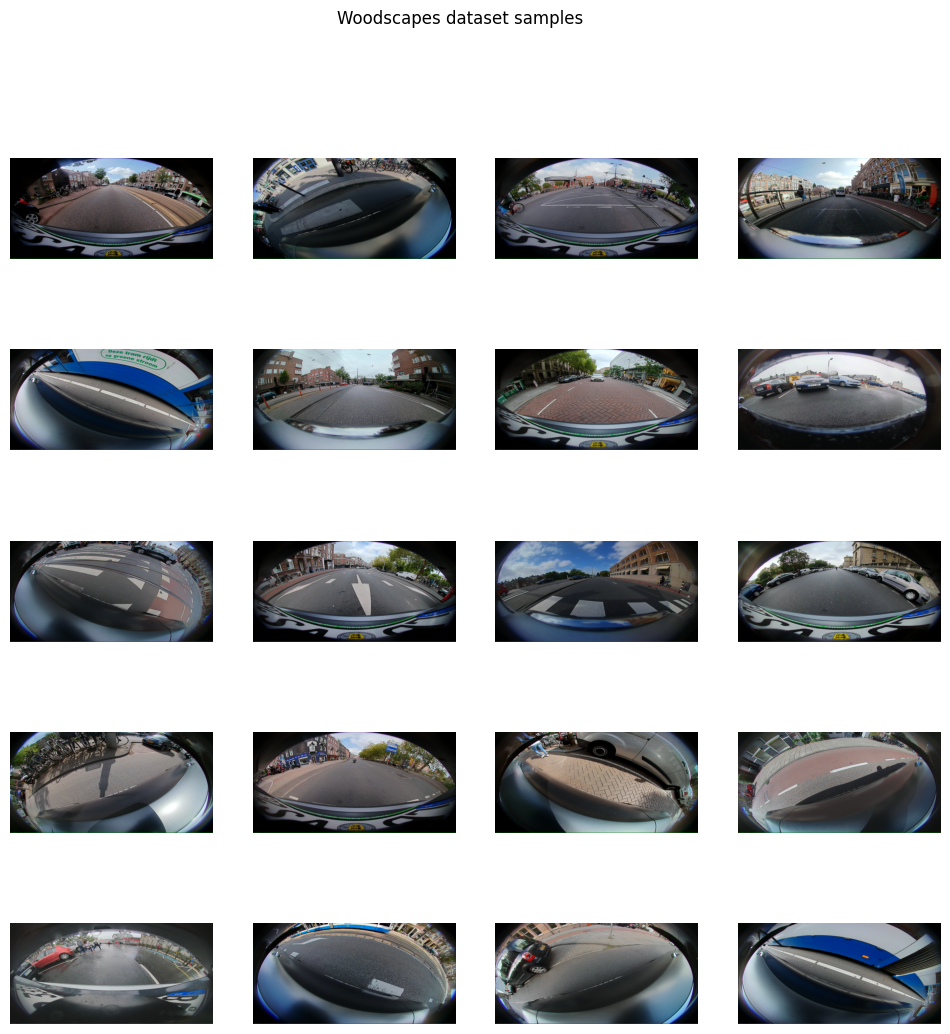

In [12]:
ws_iterator = iter(ws_256512_dlv3p_valid_loader)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = ws_dm_normal_dlv3p_256_512.unprocess_image(next(ws_iterator)[0], return_array=True)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Woodscapes dataset samples")
plt.show()

### OoD anomalies

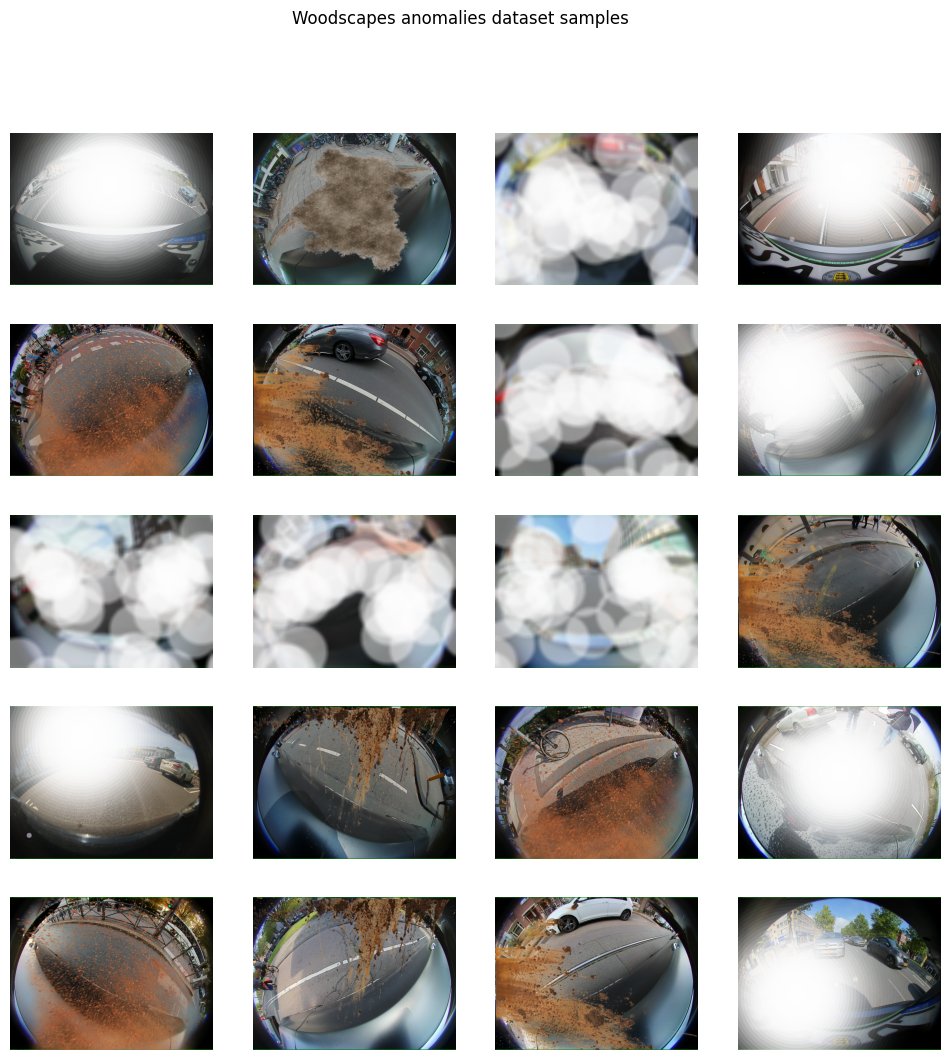

In [13]:
ws_anomaly_iterator = iter(ws_dlv3p_anomaly_test_loader)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = ws_dm_normal_dlv3p_256_512.unprocess_image(next(ws_anomaly_iterator)[0], return_array=True)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Woodscapes anomalies dataset samples")
plt.show()

### OoD soiling

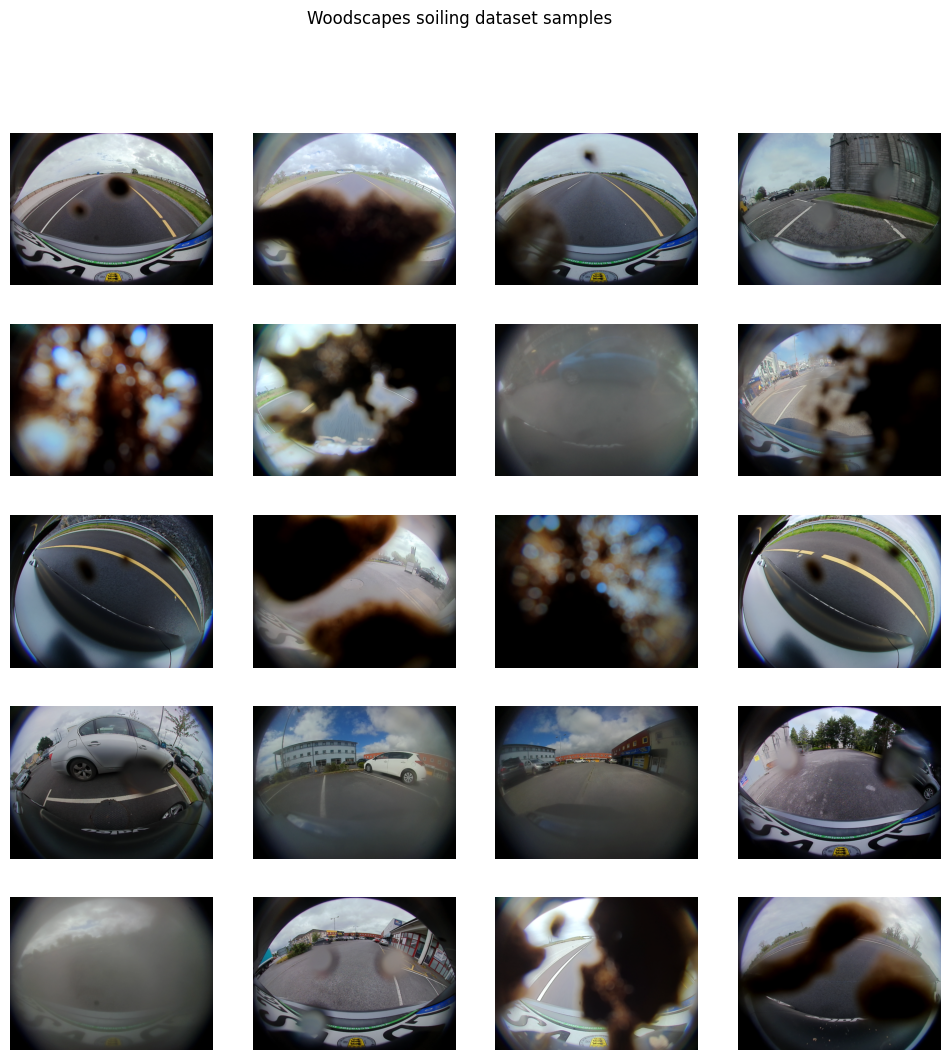

In [14]:
ws_soiling_iterator = iter(ws_soiling_483640_valid_loader)
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = woodscape_soil_483640_dm.unprocess_image(next(ws_soiling_iterator)[0], return_array=True)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Woodscapes soiling dataset samples")
plt.show()

So the goal is to build a classifier, starting from the trained model, and needing no OoD samples for training it, only the InD data, to distinguish InD from the OoD images.

# Load Deeplabv3+ Woodscape Trained Model

In [15]:
ws_dlv3p_path = "./checkpoints/last.ckpt"
ws_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=ws_dlv3p_path)

In [16]:
ic(ws_dlv3p_model.pred_loss_type)
ic(ws_dlv3p_model.n_class)

ic| ws_dlv3p_model.pred_loss_type: 'focal_loss'
ic| ws_dlv3p_model.n_class: 10


10

## Add Hook Deeplabv3+ Woodscape

In [17]:
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1)
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob)
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training)

ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1: DropBlock2D()
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.2
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training: True


True

In [18]:
ws_dlv3p_hook_dropblock2d_layer = Hook(ws_dlv3p_model.deeplab_v3plus_model.drop_block1)

# Get Monte Carlo Samples

This will take some time, be sure to run on GPU

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
mc_samples = 16

In [21]:
ws_dlv3p_model.deeplab_v3plus_model.to(device)
ws_dlv3p_model.deeplab_v3plus_model.eval()
ws_dlv3p_model.deeplab_v3plus_model.apply(apply_dropout)  # enable Dropblock

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [22]:
# Check that Dropblock is enabled
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob)
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training)

ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.2
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training: True


True

In [ ]:
ws_dlv3p_ws_normal_train_mc_samples = get_latent_representation_mcd_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                                            ws_dlv3p_train_loader,
                                                                            mc_samples,
                                                                            ws_dlv3p_hook_dropblock2d_layer,
                                                                            layer_type)

ws_dlv3p_ws_normal_valid_mc_samples = get_latent_representation_mcd_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                                            ws_dlv3p_valid_loader,
                                                                            mc_samples,
                                                                            ws_dlv3p_hook_dropblock2d_layer,
                                                                            layer_type)

ws_dlv3p_ws_normal_test_mc_samples = get_latent_representation_mcd_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                                           ws_dlv3p_test_loader,
                                                                           mc_samples,
                                                                           ws_dlv3p_hook_dropblock2d_layer,
                                                                           layer_type)

In [ ]:
ws_dlv3p_ws_anomal_valid_mc_samples = get_latent_representation_mcd_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                                            ws_dlv3p_anomaly_valid_loader,
                                                                            mc_samples,
                                                                            ws_dlv3p_hook_dropblock2d_layer,
                                                                            layer_type)

ws_dlv3p_ws_anomal_test_mc_samples = get_latent_representation_mcd_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                                           ws_dlv3p_anomaly_test_loader,
                                                                           mc_samples,
                                                                           ws_dlv3p_hook_dropblock2d_layer,
                                                                           layer_type)

In [ ]:
ws_dlv3p_ws_soiling_483640_valid_mc_samples = get_latent_representation_mcd_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                                                    ws_soiling_483640_valid_loader,
                                                                                    mc_samples,
                                                                                    ws_dlv3p_hook_dropblock2d_layer,
                                                                                    layer_type)

ws_dlv3p_ws_soiling_483640_test_mc_samples = get_latent_representation_mcd_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                                                   ws_soiling_483640_test_loader,
                                                                                   mc_samples,
                                                                                   ws_dlv3p_hook_dropblock2d_layer,
                                                                                   layer_type)

Optionally save MCD predictions

In [ ]:
torch.save(ws_dlv3p_ws_normal_train_mc_samples,
           './mc_samples/ws_dlv3p_ws_normal_train_mc_samples.pt')
torch.save(ws_dlv3p_ws_normal_valid_mc_samples,
           './mc_samples/ws_dlv3p_ws_normal_valid_mc_samples.pt')
torch.save(ws_dlv3p_ws_normal_test_mc_samples,
           './mc_samples/ws_dlv3p_ws_normal_test_mc_samples.pt')

In [ ]:
torch.save(ws_dlv3p_ws_anomal_valid_mc_samples,
           './mc_samples/ws_dlv3p_ws_anomal_valid_mc_samples.pt')
torch.save(ws_dlv3p_ws_anomal_test_mc_samples,
           './mc_samples/ws_dlv3p_ws_anomal_test_mc_samples.pt')

In [ ]:
torch.save(ws_dlv3p_ws_soiling_483640_valid_mc_samples,
           './mc_samples/ws_dlv3p_ws_soiling_483640_valid_mc_samples.pt')
torch.save(ws_dlv3p_ws_soiling_483640_test_mc_samples,
           './mc_samples/ws_dlv3p_ws_soiling_483640_test_mc_samples.pt')

In [ ]:
ws_dlv3p_ws_normal_train_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_normal_train_mc_samples.pt')
ws_dlv3p_ws_normal_valid_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_normal_valid_mc_samples.pt')
ws_dlv3p_ws_normal_test_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_normal_test_mc_samples.pt')

ws_dlv3p_ws_anomal_valid_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_anomal_valid_mc_samples.pt')
ws_dlv3p_ws_anomal_test_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_anomal_test_mc_samples.pt')

ws_dlv3p_ws_soiling_483640_valid_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_soiling_483640_valid_mc_samples.pt')
ws_dlv3p_ws_soiling_483640_test_mc_samples = torch.load('./mc_samples/ws_dlv3p_ws_soiling_483640_test_mc_samples.pt')

# Get entropy

In [ ]:
_, ws_dlv3p_h_z_ws_normal_train_samples_np = get_dl_h_z(ws_dlv3p_ws_normal_train_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_normal_valid_samples_np = get_dl_h_z(ws_dlv3p_ws_normal_valid_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_normal_test_samples_np = get_dl_h_z(ws_dlv3p_ws_normal_test_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_anomal_valid_samples_np = get_dl_h_z(ws_dlv3p_ws_anomal_valid_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_anomal_test_samples_np = get_dl_h_z(ws_dlv3p_ws_anomal_test_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_soil_483640_valid_samples_np = get_dl_h_z(ws_dlv3p_ws_soiling_483640_valid_mc_samples, mcd_samples_nro=mc_samples)
_, ws_dlv3p_h_z_ws_soil_483640_test_samples_np = get_dl_h_z(ws_dlv3p_ws_soiling_483640_test_mc_samples, mcd_samples_nro=mc_samples)

In [ ]:
np.save('./entropy/woodscapes_h_z_train',
        ws_dlv3p_h_z_ws_normal_train_samples_np)

np.save('./entropy/woodscapes_h_z_valid',
        ws_dlv3p_h_z_ws_normal_valid_samples_np)

np.save('./entropy/woodscapes_h_z_test',
        ws_dlv3p_h_z_ws_normal_test_samples_np)

np.save('./entropy/woodscapes_anomal_h_z_valid',
        ws_dlv3p_h_z_ws_anomal_valid_samples_np)

np.save('./entropy/woodscapes_anomal_h_z_test',
        ws_dlv3p_h_z_ws_anomal_test_samples_np)

np.save('./entropy/woodscapes_soil_h_z_valid',
        ws_dlv3p_h_z_ws_soil_483640_valid_samples_np)

np.save('./entropy/woodscapes_soil_h_z_test',
        ws_dlv3p_h_z_ws_soil_483640_test_samples_np)

Save the entropy samples for later use.

Further analysis is performed on the next notebook: [Notebook 2: Evaluate LaREx](https://git.irt-systemx.fr/confianceai/ec_3/n6_monitoring/component-latent-space/ood-latent-space/-/blob/4-finish-library/examples/2_example_deeplab_segmentation_analysis.ipynb?ref_type=heads)